In [1]:
import pandas as pd

# Replace 'my_data.csv' with your CSV file path or URL
csv_file_path = 'acndata_sessions.csv'

# Read the CSV into a DataFrame
df = pd.read_csv(csv_file_path)

# Print the first 5 rows
df.head()

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,5bc90cb9f9af8b0d7fe77cd2,39,"Wed, 25 Apr 2018 11:08:04 GMT","Wed, 25 Apr 2018 13:20:10 GMT","Wed, 25 Apr 2018 13:21:10 GMT",7.932,2_39_78_362_2018-04-25 11:08:04.400812,2,CA-496,2-39-78-362,America/Los_Angeles,NaN,NaN
1,5bc90cb9f9af8b0d7fe77cd3,39,"Wed, 25 Apr 2018 13:45:10 GMT","Thu, 26 Apr 2018 00:56:16 GMT","Wed, 25 Apr 2018 16:44:15 GMT",10.013,2_39_95_27_2018-04-25 13:45:09.617470,2,CA-319,2-39-95-27,America/Los_Angeles,NaN,NaN
2,5bc90cb9f9af8b0d7fe77cd4,39,"Wed, 25 Apr 2018 13:45:50 GMT","Wed, 25 Apr 2018 23:04:45 GMT","Wed, 25 Apr 2018 14:51:44 GMT",5.257,2_39_79_380_2018-04-25 13:45:49.962001,2,CA-489,2-39-79-380,America/Los_Angeles,NaN,NaN
3,5bc90cb9f9af8b0d7fe77cd5,39,"Wed, 25 Apr 2018 14:37:06 GMT","Wed, 25 Apr 2018 23:55:34 GMT","Wed, 25 Apr 2018 16:05:22 GMT",5.177,2_39_79_379_2018-04-25 14:37:06.460772,2,CA-327,2-39-79-379,America/Los_Angeles,NaN,NaN
4,5bc90cb9f9af8b0d7fe77cd6,39,"Wed, 25 Apr 2018 14:40:34 GMT","Wed, 25 Apr 2018 23:03:12 GMT","Wed, 25 Apr 2018 17:40:30 GMT",10.119,2_39_79_381_2018-04-25 14:40:33.638896,2,CA-490,2-39-79-381,America/Los_Angeles,NaN,NaN


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load your DataFrame (assuming you've already loaded it into 'df')
# df = pd.read_csv('your_data.csv')  # Example if starting from CSV

# 2. Convert time columns to datetime
df['connectionTime'] = pd.to_datetime(df['connectionTime'],
                                      format='%a, %d %b %Y %H:%M:%S GMT',
                                      errors='coerce')
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'],
                                      format='%a, %d %b %Y %H:%M:%S GMT',
                                      errors='coerce')

# 3. Create a numeric feature: total connected duration (hours)
df['connected_duration_hours'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600

# 4. Define features (X) and target (y)
X = df[['connected_duration_hours']]  # You could add more features here
y = df['kWhDelivered']

# 5. Split into training and testing sets
# Adjust test_size or random_state as needed
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Initialize and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 7. Make predictions on the test set
y_pred = model.predict(X_test)

# 8. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== Model Evaluation ===")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R-squared (R²):         {r2:.3f}")
print("========================\n")

print("=== Model Coefficients ===")
print(f"Coefficient for connected_duration_hours: {model.coef_[0]:.3f}")
print(f"Intercept:                                 {model.intercept_:.3f}")

=== Model Evaluation ===
Mean Squared Error (MSE): 33.293
R-squared (R²):         0.090

=== Model Coefficients ===
Coefficient for connected_duration_hours: 0.296
Intercept:                                 7.294


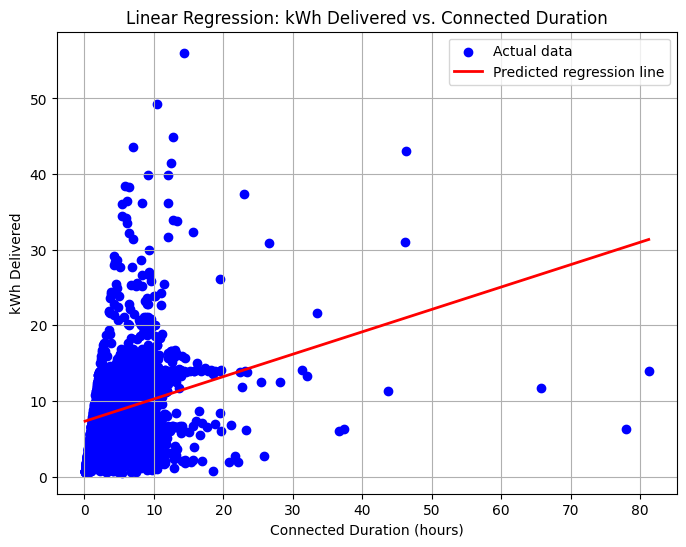

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# After training your model (see the previous code snippet):
# model = LinearRegression()
# model.fit(X_train, y_train)

# 1. Predict on the test set
y_pred = model.predict(X_test)

# 2. Create a scatter plot for the actual test data
plt.figure(figsize=(8, 6))
plt.scatter(X_test['connected_duration_hours'], y_test, color='blue', label='Actual data')

# 3. Sort the test set by 'connected_duration_hours' so we can draw a proper line
X_test_sorted = X_test.sort_values(by='connected_duration_hours')
y_pred_sorted = model.predict(X_test_sorted)

# 4. Plot the regression line
plt.plot(X_test_sorted['connected_duration_hours'], y_pred_sorted, color='red', linewidth=2, label='Predicted regression line')

# 5. Label the axes and add a title
plt.xlabel('Connected Duration (hours)')
plt.ylabel('kWh Delivered')
plt.title('Linear Regression: kWh Delivered vs. Connected Duration')
plt.legend()
plt.grid(True)

# 6. Display the plot
plt.show()